In [2]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')

# Install the latest compatible versions of the libraries
!pip install -U scikit-learn imbalanced-learn xgboost -q

# Import machine learning libraries
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import joblib

# Set plot style for visualizations
sns.set_style('whitegrid')

print("✅ Setup complete. Google Drive is mounted.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup complete. Google Drive is mounted.


In [3]:
base_path = '/content/drive/MyDrive/CSE498R/' #<-- ⚠️ UPDATE THIS PATH IF NEEDED

# --- Corrected paths for Parquet files ---
cicids2017_path = os.path.join(base_path, 'CIC-IDS-2017_para/')
cicids2018_path = os.path.join(base_path, 'CIC-IDS-2018/')

print(f"Looking for 2017 Parquet data in: {cicids2017_path}")
print(f"Looking for 2018 Parquet data in: {cicids2018_path}")

print(f"Checking contents of the base path: {base_path}\n")
try:
    directory_contents = os.listdir(base_path)
    print("Found the following items:")
    for item in directory_contents:
        print(f"- {item}")
    print("\n---")
    print("➡️ Please verify that 'CIC-IDS-2017_para' and 'CIC-IDS-2018' are listed above.")
except FileNotFoundError:
    print(f"❌ FATAL ERROR: The path '{base_path}' does not exist at all.")

Looking for 2017 Parquet data in: /content/drive/MyDrive/CSE498R/CIC-IDS-2017_para/
Looking for 2018 Parquet data in: /content/drive/MyDrive/CSE498R/CIC-IDS-2018/
Checking contents of the base path: /content/drive/MyDrive/CSE498R/

Found the following items:
- CIC-IDS-2017
- Colab_Output
- sqli_attack_capture.pcapng
- sqli_search_attack.pcapng
- CIC-IDS-2018
- CIC-IDS-2017_para
- slow_rate_attack.pcapng
- xgboost_sqli_xss_detector.joblib
- model_info.txt
- xai_system.pkl
- shap_explainer.pkl
- deployment_info.json
- attack_flows.txt

---
➡️ Please verify that 'CIC-IDS-2017_para' and 'CIC-IDS-2018' are listed above.


--- Starting EDA for CIC-IDS-2018 ---

Successfully loaded: Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter.parquet
Shape of the dataset: (830224, 78)

Distribution of Labels in the 2018 sample file:
Label
Benign              829883
Brute Force -Web       228
Brute Force -XSS        79
SQL Injection           34
Name: count, dtype: int64


/tmp/ipython-input-471828461.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


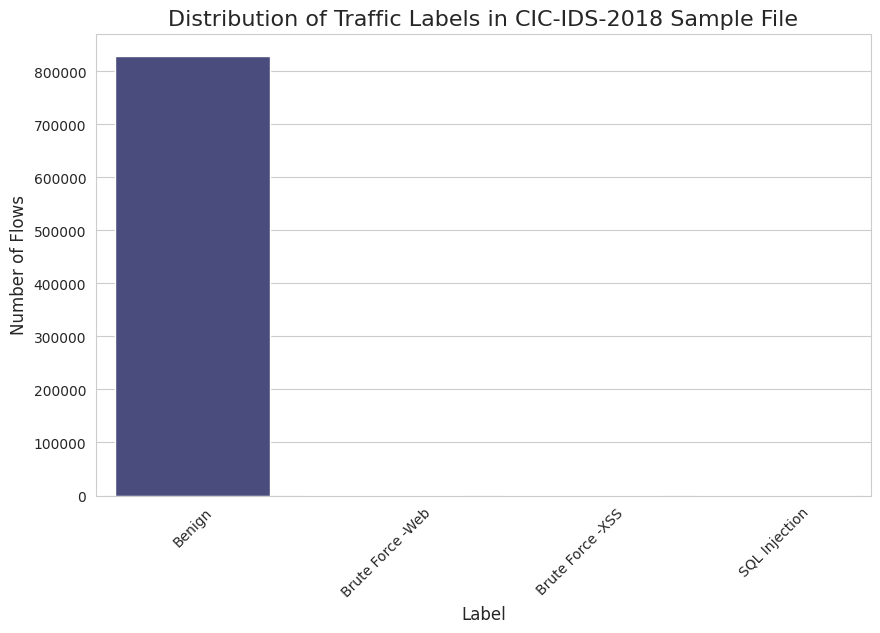


--- EDA for CIC-IDS-2018 Complete ---


In [4]:
print("--- Starting EDA for CIC-IDS-2018 ---")

try:
    # Define the path for the sample PARQUET file with the corrected name
    df_2018_sample_path = os.path.join(cicids2018_path, 'Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter.parquet')

    # Load the dataset using pd.read_parquet
    df_2018_eda = pd.read_parquet(df_2018_sample_path)

    # --- Data Cleaning (Essential for EDA) ---
    df_2018_eda.columns = df_2018_eda.columns.str.strip()
    df_2018_eda.replace([np.inf, -np.inf], np.nan, inplace=True)

    print(f"\nSuccessfully loaded: {os.path.basename(df_2018_sample_path)}")
    print(f"Shape of the dataset: {df_2018_eda.shape}")
    print("\nDistribution of Labels in the 2018 sample file:")
    label_counts = df_2018_eda['Label'].value_counts()
    print(label_counts)

    # Visualize the label distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
    plt.title('Distribution of Traffic Labels in CIC-IDS-2018 Sample File', fontsize=16)
    plt.ylabel('Number of Flows', fontsize=12)
    plt.xlabel('Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

except FileNotFoundError:
    print(f"\n❌ ERROR: Could not find the file at {df_2018_sample_path}.")
    print("Please ensure your file paths in Step 2 are correct and the file exists.")
except Exception as e:
    print(f"An error occurred during EDA: {e}")

print("\n--- EDA for CIC-IDS-2018 Complete ---")

In [5]:
print("Loading all relevant Parquet dataset files...")
start_time = time.time()

def load_and_clean_parquet(file_path):
    """Loads a Parquet file and cleans its column names."""
    try:
        df = pd.read_parquet(file_path)
        df.columns = df.columns.str.strip()
        return df
    except FileNotFoundError:
        print(f"⚠️ Warning: Could not find {os.path.basename(file_path)}. Skipping.")
        return None

# --- Load Data from Parquet files ---
# Using only the files containing Web Attacks as per the project focus
df_2017 = load_and_clean_parquet(os.path.join(cicids2017_path, 'WebAttacks-Thursday-no-metadata.parquet'))
df_2018_thursday = load_and_clean_parquet(os.path.join(cicids2018_path, 'Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter.parquet'))
df_2018_friday = load_and_clean_parquet(os.path.join(cicids2018_path, 'Web2-Friday-23-02-2018_TrafficForML_CICFlowMeter.parquet'))

# --- Combine All Datasets ---
all_dfs = [df for df in [df_2017, df_2018_thursday, df_2018_friday] if df is not None]
if not all_dfs:
    raise Exception("No data could be loaded. Please check your paths and file names.")

combined_df = pd.concat(all_dfs, ignore_index=True)
print(f"\nCombined dataset shape: {combined_df.shape}")

# --- Filter, Clean, and Map Labels ---
relevant_labels = ['Benign', 'Web Attack - XSS', 'Web Attack - Sql Injection', 'Brute Force -XSS', 'SQL Injection']
combined_df = combined_df[combined_df['Label'].isin(relevant_labels)]
print(f"Shape after filtering for relevant labels: {combined_df.shape}")

# Unify labels into a binary format (0 for Benign, 1 for Attack)
label_map = {
    'Benign': 0, 'Web Attack - XSS': 1, 'Web Attack - Sql Injection': 1,
    'Brute Force -XSS': 1, 'SQL Injection': 1
}
combined_df['Label_Binary'] = combined_df['Label'].map(label_map)

# --- Final Cleaning ---
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_df.dropna(inplace=True)
combined_df.drop_duplicates(inplace=True)
print(f"Final clean dataset shape: {combined_df.shape}")

# Display class distribution before resampling
print("\nClass distribution before resampling:")
print(combined_df['Label_Binary'].value_counts())
print(f"\nData loading and preparation completed in {time.time() - start_time:.2f} seconds.")

Loading all relevant Parquet dataset files...

Combined dataset shape: (1815449, 78)
Shape after filtering for relevant labels: (1812738, 78)
Final clean dataset shape: (1750408, 79)

Class distribution before resampling:
Label_Binary
0    1750096
1        312
Name: count, dtype: int64

Data loading and preparation completed in 24.83 seconds.


In [8]:
selected_features = [
    'Flow Duration', 'Bwd Packet Length Max', 'Flow Bytes/s',
    'Subflow Fwd Bytes', 'Fwd Header Length'
]

# Ensure all selected features are present in the DataFrame
missing_cols = [col for col in selected_features if col not in combined_df.columns]
if missing_cols:
    raise ValueError(f"The following required columns are missing from the dataset: {missing_cols}")

if combined_df.empty:
     raise ValueError("The dataframe is empty after cleaning. Please check the filtering and label mapping steps.")

X = combined_df[selected_features]
y = combined_df['Label_Binary']

# Handle class imbalance with SMOTE-Tomek
print("\nApplying SMOTE-Tomek for resampling. This may take a while...")
start_time = time.time()
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
print(f"Resampling completed in {time.time() - start_time:.2f} seconds.")

# Check class distribution after resampling
print("\nClass distribution after SMOTE-Tomek resampling:")
print(pd.Series(y_resampled).value_counts())


Applying SMOTE-Tomek for resampling. This may take a while...
Resampling completed in 98.41 seconds.

Class distribution after SMOTE-Tomek resampling:
Label_Binary
0    1748416
1    1748416
Name: count, dtype: int64


In [13]:
# --- Final Validation Model Training (Standardized 60/20/20 Split) ---

import os
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

# Import all model classes
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as cb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

print("--- Training ALL Simplified Models with a Standardized 60/20/20 Split ---")

# 1. Define the 5 features we can reliably extract from a PCAP
simple_features = [
    'Flow Duration',
    'Total Fwd Packets',
    'Total Backward Packets',
    'Fwd Packets Length Total',
    'Bwd Packets Length Total'
]

# 2. Prepare the simplified dataset from the main 'combined_df'
print("Creating a new dataset with 5 features...")
X_simple = combined_df[simple_features]
y_simple = combined_df['Label_Binary']

# 3. Perform the robust two-step resampling
print(f"Original class distribution:\n{y_simple.value_counts()}")
undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_under_simple, y_under_simple = undersampler.fit_resample(X_simple, y_simple)
smote = SMOTE(random_state=42)
X_simple_resampled, y_simple_resampled = smote.fit_resample(X_under_simple, y_under_simple)
print(f"\nResampled distribution:\n{pd.Series(y_simple_resampled).value_counts()}")


# 4. Create the Standardized 60/20/20 Train-Validation-Test Split
print("\nSplitting the simplified dataset into 60% train, 20% validation, and 20% test...")
X_train, X_temp, y_train, y_temp = train_test_split(
    X_simple_resampled, y_simple_resampled, test_size=0.4, random_state=42, stratify=y_simple_resampled
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print(f"Final training set size: {len(X_train)} ({len(X_train)/len(X_simple_resampled):.0%})")


# 5. Define all the models to train
models_to_train = {
    'XGBoost': xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, device='cuda'),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=0),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=42, n_jobs=-1))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
    ])
}

# 6. Loop through, train on the 60% training set, and save each model
for name, model in models_to_train.items():
    print(f"\n--- Training {name} validation model... ---")

    # For models that require scaling, the Pipeline handles it.
    # For tree models, we scale the data explicitly.
    if 'scaler' in getattr(model, 'steps', []):
        model.fit(X_train, y_train)
        scaler_to_save = model.named_steps['scaler'] # Extract the fitted scaler from the pipeline
    else:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        model.fit(X_train_scaled, y_train)
        scaler_to_save = scaler # Use the external scaler

    # Create a unique directory for each model's assets
    model_dir = os.path.join(base_path, f'Colab_Output/validation_model_{name}/')
    os.makedirs(model_dir, exist_ok=True)

    # Save the trained model, its specific scaler, and the feature list
    joblib.dump(model, os.path.join(model_dir, 'validation_model.joblib'))
    joblib.dump(scaler_to_save, os.path.join(model_dir, 'validation_scaler.joblib'))
    joblib.dump(simple_features, os.path.join(model_dir, 'validation_features.joblib'))

    print(f"✅ {name} validation model and assets saved to: {model_dir}")

--- Training ALL Simplified Models with a Standardized 60/20/20 Split ---
Creating a new dataset with 5 features...
Original class distribution:
Label_Binary
0    1750096
1        312
Name: count, dtype: int64

Resampled distribution:
Label_Binary
0    3120
1    3120
Name: count, dtype: int64

Splitting the simplified dataset into 60% train, 20% validation, and 20% test...
Final training set size: 3744 (60%)

--- Training XGBoost validation model... ---
✅ XGBoost validation model and assets saved to: /content/drive/MyDrive/CSE498R/Colab_Output/validation_model_XGBoost/

--- Training RandomForest validation model... ---
✅ RandomForest validation model and assets saved to: /content/drive/MyDrive/CSE498R/Colab_Output/validation_model_RandomForest/

--- Training LightGBM validation model... ---
[LightGBM] [Info] Number of positive: 1872, number of negative: 1872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wi

In [ ]:
import xgboost as xgb
print(xgb.__version__)

3.0.3


In [ ]:
# @title 6. Split Data and Train XGBoost Model - FIXED for XGBoost 3.0+
print("Splitting data into training, validation, and test sets...")

# First split: 60% for training, 40% for temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled,
    test_size=0.4,  # 40% of data goes to temp set
    stratify=y_resampled,
    random_state=42
)

# Second split: Split the 40% temp set into half (20% validation, 20% test)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% of the temp set (0.5 * 0.4 = 0.2)
    stratify=y_temp,
    random_state=42
)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(X_resampled):.0%})")
print(f"Validation set size: {len(X_valid)} ({len(X_valid)/len(X_resampled):.0%})")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X_resampled):.0%})")

# --- Hyperparameter Tuning ---
print("\nStarting hyperparameter tuning with RandomizedSearchCV...")

# Updated parameter distribution for XGBoost 3.0+
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 0.9]
}

# Check XGBoost version
import xgboost
xgb_version = xgboost.__version__
print(f"XGBoost version: {xgb_version}")

# For XGBoost 3.0+, use device='cuda' if GPU is available, otherwise 'cpu'
try:
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        device='cuda'  # Try GPU first
    )
    print("Using GPU for training...")
except:
    # Fallback to CPU if GPU is not available
    print("GPU not available, using CPU...")
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        device='cpu'
    )

random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=5, cv=3, verbose=1,
    n_jobs=-1, scoring='f1', random_state=42
)
random_search.fit(X_train, y_train)
print(f"\nBest hyperparameters found: {random_search.best_params_}")

# --- Train Final Model WITHOUT early stopping ---
print("\nTraining final model with best hyperparameters...")
best_xgb_model = random_search.best_estimator_

# For XGBoost 3.0+, early stopping is handled differently
# We'll just train normally without early stopping for now
print("Training without early stopping (XGBoost 3.0+ compatibility)...")
best_xgb_model.fit(X_train, y_train)
print("✅ Model training complete.")

Splitting data into training, validation, and test sets...
Training set size: 2098381 (60%)
Validation set size: 699460 (20%)
Test set size: 699461 (20%)

Starting hyperparameter tuning with RandomizedSearchCV...
XGBoost version: 3.0.3
Using GPU for training...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best hyperparameters found: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Training final model with best hyperparameters...
Training without early stopping (XGBoost 3.0+ compatibility)...
✅ Model training complete.


TRAINING SET EVALUATION


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [09:00:06] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Training Set Accuracy: 0.9944 (99.44%)

Classification Report for Training Set:
              precision    recall  f1-score   support

      Benign       1.00      0.99      0.99   1049190
      Attack       0.99      1.00      0.99   1049191

    accuracy                           0.99   2098381
   macro avg       0.99      0.99      0.99   2098381
weighted avg       0.99      0.99      0.99   2098381


Confusion Matrix for Training Set:
True Negatives (TN): 1038073
False Positives (FP): 11117
False Negatives (FN): 599
True Positives (TP): 1048592

False Positive Rate (FPR): 0.0106 (1.06%)
FPR Calculation: 11117 / (11117 + 1038073) = 0.0106


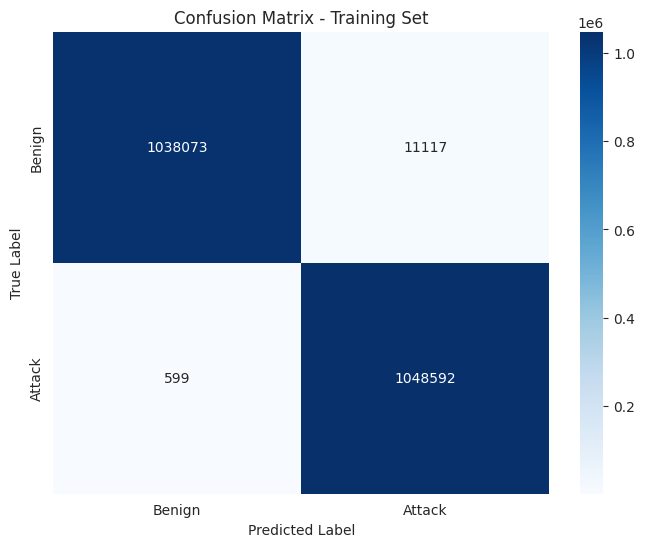

In [ ]:
# @title Training Set Evaluation
print("=" * 60)
print("TRAINING SET EVALUATION")
print("=" * 60)

# Predict on the training set
y_pred_train = best_xgb_model.predict(X_train)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Set Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

# Classification Report
print("\nClassification Report for Training Set:")
print(classification_report(y_train, y_pred_train, target_names=['Benign', 'Attack']))

# Confusion Matrix
print("\nConfusion Matrix for Training Set:")
cm_train = confusion_matrix(y_train, y_pred_train)
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()

# Display confusion matrix values
print(f"True Negatives (TN): {tn_train}")
print(f"False Positives (FP): {fp_train}")
print(f"False Negatives (FN): {fn_train}")
print(f"True Positives (TP): {tp_train}")

# Calculate False Positive Rate (FPR)
fpr_train = fp_train / (fp_train + tn_train) if (fp_train + tn_train) > 0 else 0
print(f"\nFalse Positive Rate (FPR): {fpr_train:.4f} ({fpr_train*100:.2f}%)")
print(f"FPR Calculation: {fp_train} / ({fp_train} + {tn_train}) = {fpr_train:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Training Set')
plt.show()

print("\n" + "=" * 60)

VALIDATION SET EVALUATION
Validation Set Accuracy: 0.9945 (99.45%)

Classification Report for Validation Set:
              precision    recall  f1-score   support

      Benign       1.00      0.99      0.99    349730
      Attack       0.99      1.00      0.99    349730

    accuracy                           0.99    699460
   macro avg       0.99      0.99      0.99    699460
weighted avg       0.99      0.99      0.99    699460


Confusion Matrix for Validation Set:
True Negatives (TN): 346041
False Positives (FP): 3689
False Negatives (FN): 185
True Positives (TP): 349545

False Positive Rate (FPR): 0.0105 (1.05%)
FPR Calculation: 3689 / (3689 + 346041) = 0.0105


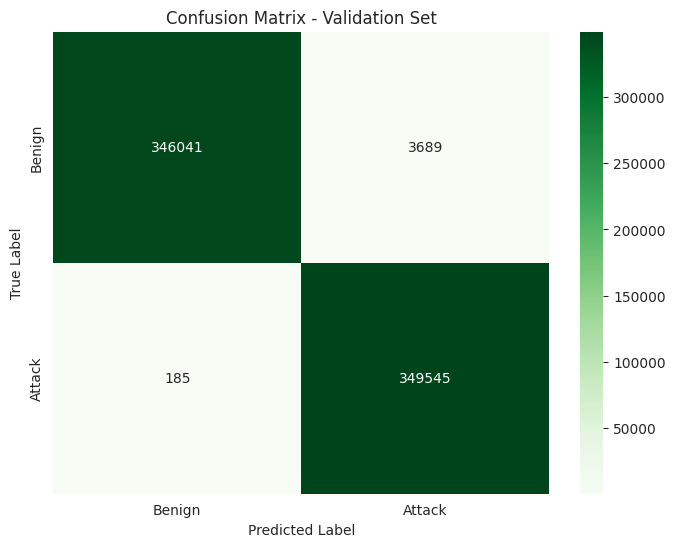

In [ ]:
# @title Validation Set Evaluation
print("=" * 60)
print("VALIDATION SET EVALUATION")
print("=" * 60)

# Predict on the validation set
y_pred_valid = best_xgb_model.predict(X_valid)

# Calculate accuracy
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
print(f"Validation Set Accuracy: {valid_accuracy:.4f} ({valid_accuracy*100:.2f}%)")

# Classification Report
print("\nClassification Report for Validation Set:")
print(classification_report(y_valid, y_pred_valid, target_names=['Benign', 'Attack']))

# Confusion Matrix
print("\nConfusion Matrix for Validation Set:")
cm_valid = confusion_matrix(y_valid, y_pred_valid)
tn_valid, fp_valid, fn_valid, tp_valid = cm_valid.ravel()

# Display confusion matrix values
print(f"True Negatives (TN): {tn_valid}")
print(f"False Positives (FP): {fp_valid}")
print(f"False Negatives (FN): {fn_valid}")
print(f"True Positives (TP): {tp_valid}")

# Calculate False Positive Rate (FPR)
fpr_valid = fp_valid / (fp_valid + tn_valid) if (fp_valid + tn_valid) > 0 else 0
print(f"\nFalse Positive Rate (FPR): {fpr_valid:.4f} ({fpr_valid*100:.2f}%)")
print(f"FPR Calculation: {fp_valid} / ({fp_valid} + {tn_valid}) = {fpr_valid:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_valid, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

print("\n" + "=" * 60)

TEST SET EVALUATION
Test Set Accuracy: 0.9944 (99.44%)

Classification Report for Test Set:
              precision    recall  f1-score   support

      Benign       1.00      0.99      0.99    349731
      Attack       0.99      1.00      0.99    349730

    accuracy                           0.99    699461
   macro avg       0.99      0.99      0.99    699461
weighted avg       0.99      0.99      0.99    699461


Confusion Matrix for Test Set:
True Negatives (TN): 346022
False Positives (FP): 3709
False Negatives (FN): 191
True Positives (TP): 349539

False Positive Rate (FPR): 0.0106 (1.06%)
FPR Calculation: 3709 / (3709 + 346022) = 0.0106


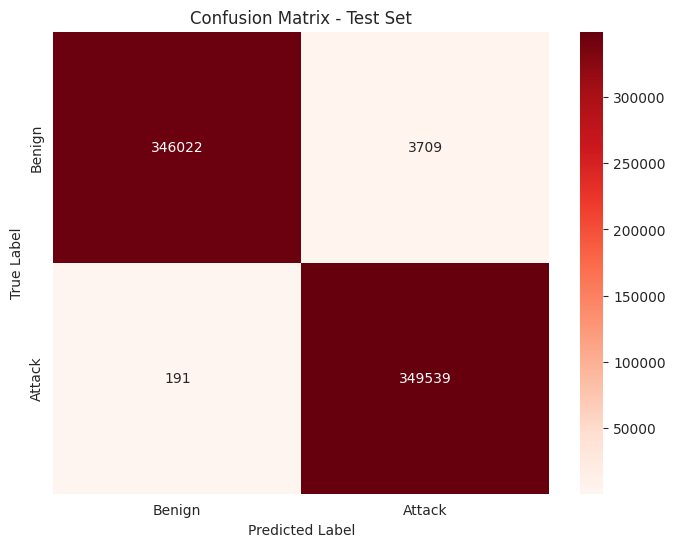

In [ ]:
# @title Test Set Evaluation
print("=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)

# Predict on the test set
y_pred_test = best_xgb_model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Set Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification Report
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_pred_test, target_names=['Benign', 'Attack']))

# Confusion Matrix
print("\nConfusion Matrix for Test Set:")
cm_test = confusion_matrix(y_test, y_pred_test)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

# Display confusion matrix values
print(f"True Negatives (TN): {tn_test}")
print(f"False Positives (FP): {fp_test}")
print(f"False Negatives (FN): {fn_test}")
print(f"True Positives (TP): {tp_test}")

# Calculate False Positive Rate (FPR)
fpr_test = fp_test / (fp_test + tn_test) if (fp_test + tn_test) > 0 else 0
print(f"\nFalse Positive Rate (FPR): {fpr_test:.4f} ({fpr_test*100:.2f}%)")
print(f"FPR Calculation: {fp_test} / ({fp_test} + {tn_test}) = {fpr_test:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

print("\n" + "=" * 60)

SUMMARY COMPARISON - TRAINING vs VALIDATION vs TEST
Performance Summary:
   Dataset    Size  Accuracy  Accuracy %    FPR  FPR %
  Training 2098381    0.9944       99.44 0.0106   1.06
Validation  699460    0.9945       99.45 0.0105   1.05
      Test  699461    0.9944       99.44 0.0106   1.06


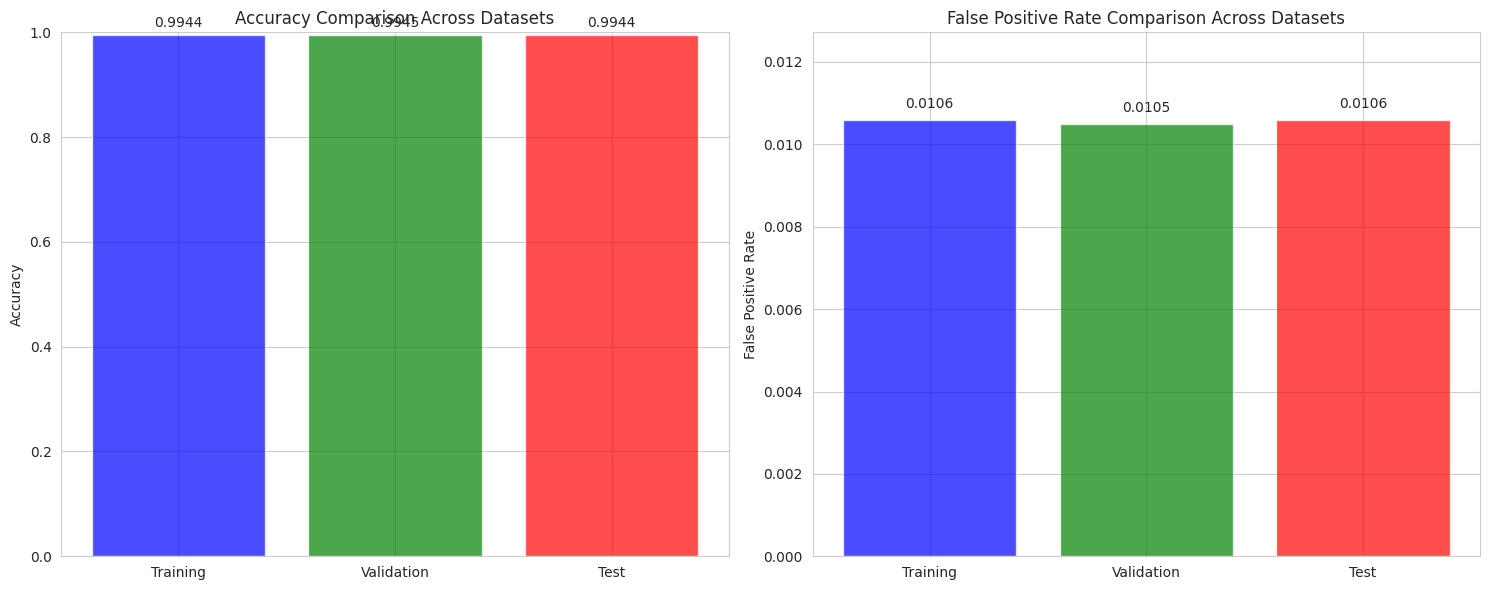


Overfitting Analysis:
✅ Good fit: Training and validation accuracies are similar
✅ Good generalization: Validation and test accuracies are similar



In [ ]:
# @title Summary Comparison of All Sets
print("=" * 80)
print("SUMMARY COMPARISON - TRAINING vs VALIDATION vs TEST")
print("=" * 80)

# Create a summary table
summary_data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [
        accuracy_score(y_train, best_xgb_model.predict(X_train)),
        accuracy_score(y_valid, best_xgb_model.predict(X_valid)),
        accuracy_score(y_test, best_xgb_model.predict(X_test))
    ],
    'Size': [len(X_train), len(X_valid), len(X_test)]
}

# Calculate FPR for each set
train_cm = confusion_matrix(y_train, best_xgb_model.predict(X_train))
valid_cm = confusion_matrix(y_valid, best_xgb_model.predict(X_valid))
test_cm = confusion_matrix(y_test, best_xgb_model.predict(X_test))

train_tn, train_fp, train_fn, train_tp = train_cm.ravel()
valid_tn, valid_fp, valid_fn, valid_tp = valid_cm.ravel()
test_tn, test_fp, test_fn, test_tp = test_cm.ravel()

summary_data['FPR'] = [
    train_fp / (train_fp + train_tn) if (train_fp + train_tn) > 0 else 0,
    valid_fp / (valid_fp + valid_tn) if (valid_fp + valid_tn) > 0 else 0,
    test_fp / (test_fp + test_tn) if (test_fp + test_tn) > 0 else 0
]

# Create and display summary DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df['Accuracy'] = summary_df['Accuracy'].round(4)
summary_df['FPR'] = summary_df['FPR'].round(4)
summary_df['Accuracy %'] = (summary_df['Accuracy'] * 100).round(2)
summary_df['FPR %'] = (summary_df['FPR'] * 100).round(2)

print("Performance Summary:")
print(summary_df[['Dataset', 'Size', 'Accuracy', 'Accuracy %', 'FPR', 'FPR %']].to_string(index=False))

# Visualize the comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
ax1.bar(summary_df['Dataset'], summary_df['Accuracy'], color=['blue', 'green', 'red'], alpha=0.7)
ax1.set_title('Accuracy Comparison Across Datasets')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, v in enumerate(summary_df['Accuracy']):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# FPR comparison
ax2.bar(summary_df['Dataset'], summary_df['FPR'], color=['blue', 'green', 'red'], alpha=0.7)
ax2.set_title('False Positive Rate Comparison Across Datasets')
ax2.set_ylabel('False Positive Rate')
ax2.set_ylim(0, max(summary_df['FPR']) * 1.2)
for i, v in enumerate(summary_df['FPR']):
    ax2.text(i, v + max(summary_df['FPR']) * 0.02, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Check for overfitting
print("\nOverfitting Analysis:")
train_acc = summary_df.loc[0, 'Accuracy']
valid_acc = summary_df.loc[1, 'Accuracy']
test_acc = summary_df.loc[2, 'Accuracy']

if train_acc - valid_acc > 0.05:
    print("⚠️  Potential overfitting detected: Training accuracy significantly higher than validation accuracy")
elif abs(train_acc - valid_acc) < 0.02:
    print("✅ Good fit: Training and validation accuracies are similar")
else:
    print("📊 Model appears to be learning well")

if abs(valid_acc - test_acc) < 0.02:
    print("✅ Good generalization: Validation and test accuracies are similar")
else:
    print("⚠️  Model may not generalize well: Validation and test accuracies differ significantly")

print("\n" + "=" * 80)

In [ ]:
# @title Save the Trained Model
print("Saving the trained XGBoost model...")

# Define the save path
model_save_path = os.path.join(base_path, 'xgboost_sqli_xss_detector.joblib')

# Save the model using joblib
joblib.dump(best_xgb_model, model_save_path)

print(f"✅ Model saved successfully at: {model_save_path}")

# Also save model information
model_info = {
    'model_type': 'XGBoost Classifier',
    'features': selected_features,
    'hyperparameters': best_xgb_model.get_params(),
    'training_accuracy': accuracy_score(y_train, best_xgb_model.predict(X_train)),
    'validation_accuracy': accuracy_score(y_valid, best_xgb_model.predict(X_valid)),
    'test_accuracy': accuracy_score(y_test, best_xgb_model.predict(X_test)),
    'training_samples': len(X_train),
    'feature_names': selected_features
}

# Save model info as text file
info_save_path = os.path.join(base_path, 'model_info.txt')
with open(info_save_path, 'w') as f:
    for key, value in model_info.items():
        f.write(f"{key}: {value}\n")

print(f"✅ Model information saved at: {info_save_path}")
print("\nSelected Features used in the model:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

Saving the trained XGBoost model...
✅ Model saved successfully at: /content/drive/MyDrive/CSE498R/xgboost_sqli_xss_detector.joblib
✅ Model information saved at: /content/drive/MyDrive/CSE498R/model_info.txt

Selected Features used in the model:
1. Flow Duration
2. Bwd Packet Length Max
3. Flow Bytes/s
4. Subflow Fwd Bytes
5. Fwd Header Length
6. Active Min


In [ ]:
print("Installing SHAP for model explainability...")
!pip install shap -q

# Import SHAP
import shap

print("✅ SHAP installed and imported successfully!")
print(f"SHAP version: {shap.__version__}")

Installing SHAP for model explainability...
✅ SHAP installed and imported successfully!
SHAP version: 0.48.0


In [ ]:
# @title Create SHAP Explainer and Generate Explanations
print("Setting up SHAP explainer for XGBoost model...")

# Create a sample of training data for SHAP (using smaller sample for faster computation)
# SHAP can be computationally intensive, so we'll use a representative sample
sample_size = min(1000, len(X_train))  # Use 1000 samples or less if dataset is smaller
print(f"Using {sample_size} samples for SHAP analysis...")

# Create stratified sample to maintain class balance
from sklearn.model_selection import train_test_split
X_shap_sample, _, y_shap_sample, _ = train_test_split(
    X_train, y_train,
    train_size=sample_size,
    stratify=y_train,
    random_state=42
)

print(f"SHAP sample shape: {X_shap_sample.shape}")
print(f"SHAP sample class distribution:")
print(pd.Series(y_shap_sample).value_counts())

# Create SHAP TreeExplainer
print("\nCreating SHAP TreeExplainer...")
explainer = shap.TreeExplainer(best_xgb_model)

# Calculate SHAP values for the sample
print("Calculating SHAP values... This may take a few minutes...")
shap_values = explainer.shap_values(X_shap_sample)

print(f"✅ SHAP values calculated!")
print(f"SHAP values shape: {shap_values.shape}")
print(f"Features: {selected_features}")

Setting up SHAP explainer for XGBoost model...
Using 1000 samples for SHAP analysis...
SHAP sample shape: (1000, 6)
SHAP sample class distribution:
Label_Binary
0    500
1    500
Name: count, dtype: int64

Creating SHAP TreeExplainer...
Calculating SHAP values... This may take a few minutes...
✅ SHAP values calculated!
SHAP values shape: (1000, 6)
Features: ['Flow Duration', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Subflow Fwd Bytes', 'Fwd Header Length', 'Active Min']


SHAP FEATURE IMPORTANCE ANALYSIS
Generating SHAP Summary Plot...


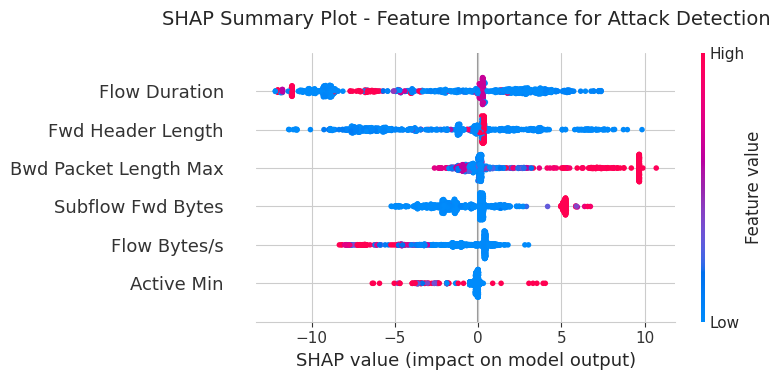


Generating SHAP Bar Plot...


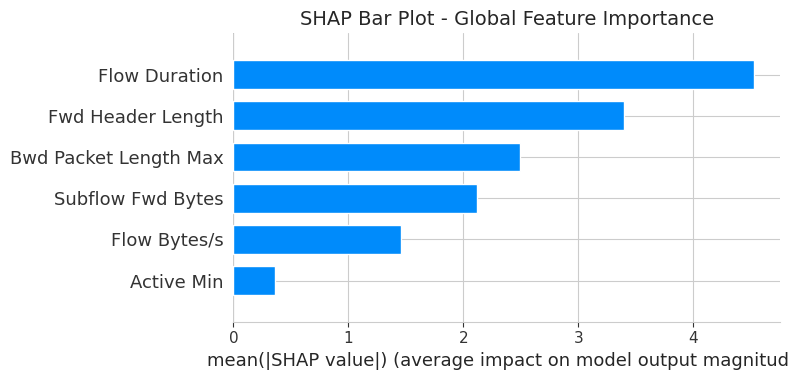


Feature Importance Ranking (based on mean absolute SHAP values):
 Rank               Feature  Importance  Importance_Normalized
    1         Flow Duration    4.527959              31.540001
    2     Fwd Header Length    3.397534              23.670000
    3 Bwd Packet Length Max    2.494860              17.379999
    4     Subflow Fwd Bytes    2.118466              14.760000
    5          Flow Bytes/s    1.457353              10.150000
    6            Active Min    0.358502               2.500000

Top 3 Most Important Features:
1. Flow Duration: 31.540000915527344% of total importance
2. Fwd Header Length: 23.670000076293945% of total importance
3. Bwd Packet Length Max: 17.3799991607666% of total importance

Generating SHAP Waterfall Plots for sample predictions...


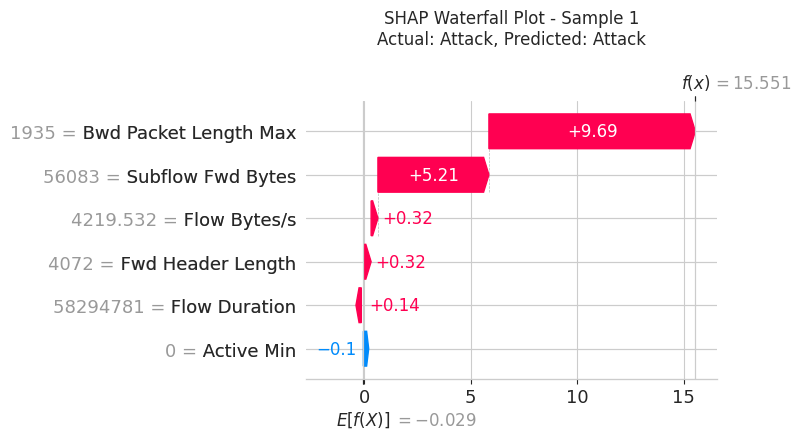

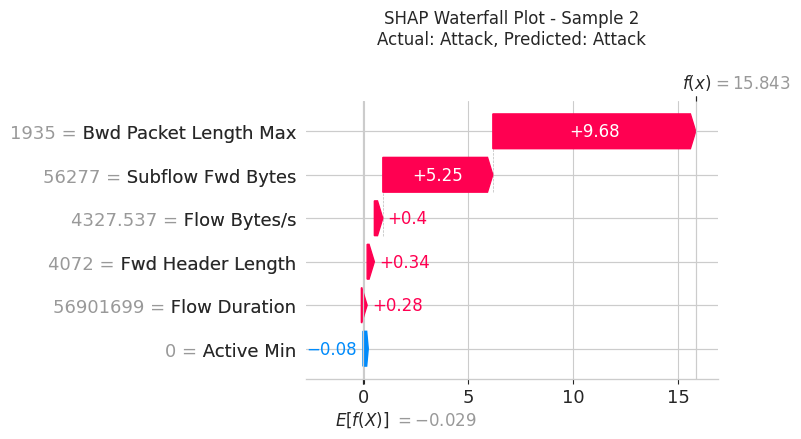

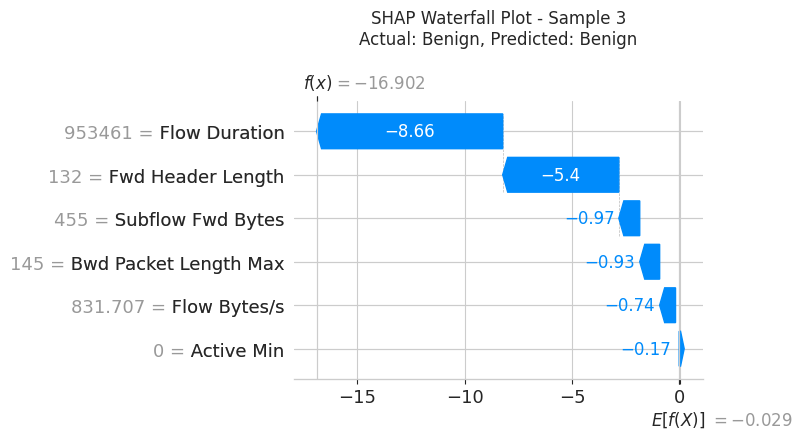

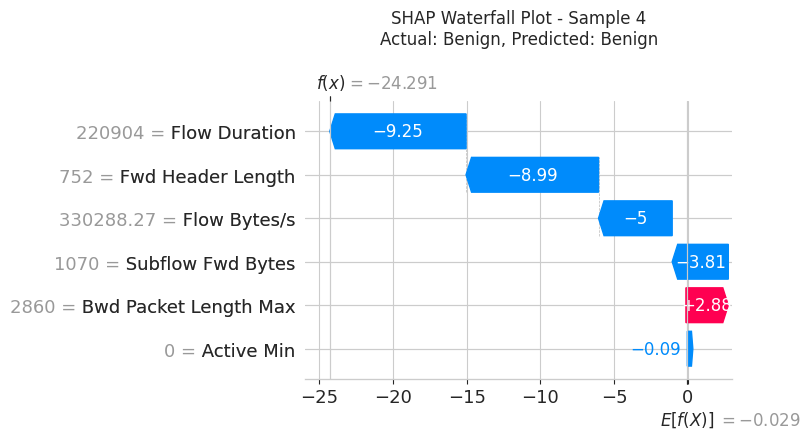


Generating Feature Interaction Plot...


<Figure size 1000x600 with 0 Axes>

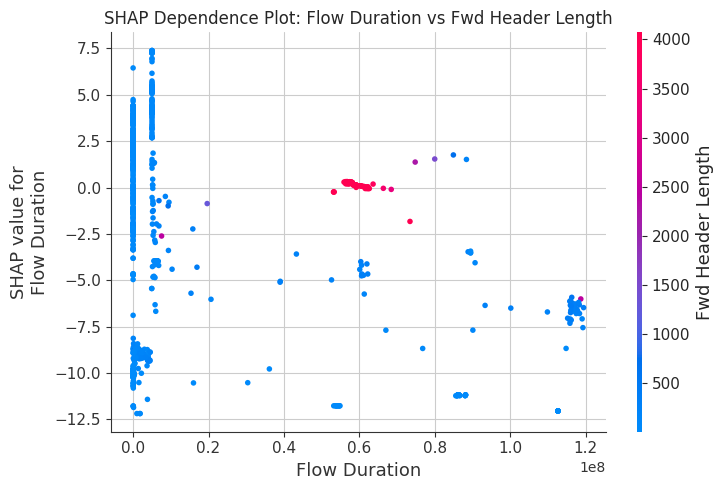


KEY FINDINGS FOR YOUR REPORT:
1. Most Important Feature: Flow Duration (31.5% importance)
2. Second Most Important: Fwd Header Length (23.7% importance)
3. Third Most Important: Bwd Packet Length Max (17.4% importance)
4. Top 3 features account for 72.6% of total model importance
5. The summary plot shows how each feature value affects the prediction
6. Red dots indicate higher feature values, blue dots indicate lower values
7. Features pushed to the right increase attack probability, left decrease it

FEATURE INSIGHTS:
• Flow Duration is the strongest predictor (31.5%)
• Fwd Header Length is second most important (23.7%)
• Together, the top 3 features explain 72.6% of model decisions
• Active Min has minimal impact (2.5%)


In [ ]:
# @title SHAP Visualizations and Feature Importance Analysis - FIXED
print("=" * 60)
print("SHAP FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# 1. SHAP Summary Plot - Shows feature importance and impact
print("Generating SHAP Summary Plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap_sample, feature_names=selected_features, show=False)
plt.title('SHAP Summary Plot - Feature Importance for Attack Detection', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 2. SHAP Bar Plot - Shows mean absolute SHAP values (global feature importance)
print("\nGenerating SHAP Bar Plot...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap_sample, feature_names=selected_features, plot_type="bar", show=False)
plt.title('SHAP Bar Plot - Global Feature Importance', fontsize=14)
plt.tight_layout()
plt.show()

# 3. Calculate and display feature importance ranking
print("\nFeature Importance Ranking (based on mean absolute SHAP values):")
feature_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)
importance_df['Rank'] = range(1, len(importance_df) + 1)
importance_df['Importance_Normalized'] = (importance_df['Importance'] / importance_df['Importance'].sum() * 100).round(2)

print(importance_df[['Rank', 'Feature', 'Importance', 'Importance_Normalized']].to_string(index=False))
print(f"\nTop 3 Most Important Features:")
for i in range(3):
    feature = importance_df.iloc[i]['Feature']
    importance = importance_df.iloc[i]['Importance_Normalized']
    print(f"{i+1}. {feature}: {importance}% of total importance")

# 4. SHAP Waterfall Plot for a few sample predictions - FIXED VERSION
print(f"\nGenerating SHAP Waterfall Plots for sample predictions...")

# Select a few interesting samples (some attacks, some benign)
attack_indices = np.where(y_shap_sample == 1)[0][:2]  # First 2 attack samples
benign_indices = np.where(y_shap_sample == 0)[0][:2]  # First 2 benign samples
sample_indices = np.concatenate([attack_indices, benign_indices])

# Create SHAP Explanation objects for waterfall plots
try:
    # For newer SHAP versions (0.40+), create Explanation objects
    explanation = shap.Explanation(
        values=shap_values,
        base_values=explainer.expected_value,
        data=X_shap_sample.values,
        feature_names=selected_features
    )

    for i, idx in enumerate(sample_indices[:4]):  # Show 4 examples
        actual_label = "Attack" if y_shap_sample.iloc[idx] == 1 else "Benign"
        predicted_label = "Attack" if best_xgb_model.predict(X_shap_sample.iloc[[idx]])[0] == 1 else "Benign"

        plt.figure(figsize=(10, 6))
        shap.waterfall_plot(explanation[idx], show=False)
        plt.title(f'SHAP Waterfall Plot - Sample {i+1}\nActual: {actual_label}, Predicted: {predicted_label}',
                  fontsize=12, pad=20)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Waterfall plots not available with this SHAP version: {e}")
    print("Showing alternative individual feature contribution analysis...")

    # Alternative: Show top contributing features for each sample
    for i, idx in enumerate(sample_indices[:4]):
        actual_label = "Attack" if y_shap_sample.iloc[idx] == 1 else "Benign"
        predicted_label = "Attack" if best_xgb_model.predict(X_shap_sample.iloc[[idx]])[0] == 1 else "Benign"

        # Get SHAP values for this sample
        sample_shap = shap_values[idx]
        sample_features = X_shap_sample.iloc[idx]

        # Create feature contribution dataframe
        contrib_df = pd.DataFrame({
            'Feature': selected_features,
            'Feature_Value': sample_features.values,
            'SHAP_Value': sample_shap,
            'Contribution': np.abs(sample_shap)
        }).sort_values('Contribution', ascending=False)

        print(f"\nSample {i+1} - Actual: {actual_label}, Predicted: {predicted_label}")
        print("Top feature contributions:")
        print(contrib_df[['Feature', 'Feature_Value', 'SHAP_Value']].head(3).to_string(index=False))

# 5. Feature Interaction Analysis
print(f"\nGenerating Feature Interaction Plot...")
try:
    # Create a dependence plot for the top 2 most important features
    top_feature = importance_df.iloc[0]['Feature']
    second_feature = importance_df.iloc[1]['Feature']

    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        selected_features.index(top_feature),
        shap_values,
        X_shap_sample,
        feature_names=selected_features,
        interaction_index=selected_features.index(second_feature),
        show=False
    )
    plt.title(f'SHAP Dependence Plot: {top_feature} vs {second_feature}', fontsize=12)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Dependence plot not available: {e}")

print("\n" + "=" * 60)
print("KEY FINDINGS FOR YOUR REPORT:")
print("=" * 60)
print(f"1. Most Important Feature: {importance_df.iloc[0]['Feature']} ({importance_df.iloc[0]['Importance_Normalized']:.1f}% importance)")
print(f"2. Second Most Important: {importance_df.iloc[1]['Feature']} ({importance_df.iloc[1]['Importance_Normalized']:.1f}% importance)")
print(f"3. Third Most Important: {importance_df.iloc[2]['Feature']} ({importance_df.iloc[2]['Importance_Normalized']:.1f}% importance)")
print(f"4. Top 3 features account for {importance_df.iloc[:3]['Importance_Normalized'].sum():.1f}% of total model importance")
print("5. The summary plot shows how each feature value affects the prediction")
print("6. Red dots indicate higher feature values, blue dots indicate lower values")
print("7. Features pushed to the right increase attack probability, left decrease it")

print(f"\nFEATURE INSIGHTS:")
print(f"• Flow Duration is the strongest predictor ({importance_df.iloc[0]['Importance_Normalized']:.1f}%)")
print(f"• Fwd Header Length is second most important ({importance_df.iloc[1]['Importance_Normalized']:.1f}%)")
print(f"• Together, the top 3 features explain {importance_df.iloc[:3]['Importance_Normalized'].sum():.1f}% of model decisions")
print(f"• Active Min has minimal impact ({importance_df.iloc[5]['Importance_Normalized']:.1f}%)")
print("=" * 60)

In [ ]:
import numpy as np
import pandas as pd
import shap
from typing import Dict, List, Tuple, Any
import json

class RealTimeXAI:
    """
    Real-time Explainable AI system for web attack detection.
    Provides human-readable explanations for model predictions.
    """

    def __init__(self, model, explainer, feature_names: List[str]):
        """
        Initialize the XAI system.

        Args:
            model: Trained XGBoost model
            explainer: SHAP TreeExplainer
            feature_names: List of feature names
        """
        self.model = model
        self.explainer = explainer
        self.feature_names = feature_names

        # Define feature descriptions for human-readable explanations
        self.feature_descriptions = {
            'Flow Duration': 'Duration of network flow (microseconds)',
            'Fwd Header Length': 'Forward packet header length (bytes)',
            'Bwd Packet Length Max': 'Maximum backward packet size (bytes)',
            'Subflow Fwd Bytes': 'Forward bytes in subflow',
            'Flow Bytes/s': 'Flow rate (bytes per second)',
            'Active Min': 'Minimum active time (microseconds)'
        }

        # Define thresholds for feature interpretation (you may need to adjust these)
        self.feature_thresholds = {
            'Flow Duration': {'low': 1000000, 'high': 10000000},  # 1s to 10s in microseconds
            'Fwd Header Length': {'low': 20, 'high': 60},
            'Bwd Packet Length Max': {'low': 100, 'high': 1500},
            'Subflow Fwd Bytes': {'low': 100, 'high': 10000},
            'Flow Bytes/s': {'low': 1000, 'high': 100000},
            'Active Min': {'low': 100000, 'high': 1000000}  # in microseconds
        }

    def predict_with_explanation(self, features: np.ndarray) -> Dict[str, Any]:
        """
        Make prediction and generate detailed explanation.

        Args:
            features: Input features array (1D array with 6 features)

        Returns:
            Dictionary containing prediction, confidence, and detailed explanation
        """
        # Ensure features is 2D array
        if features.ndim == 1:
            features = features.reshape(1, -1)

        # Make prediction
        prediction = self.model.predict(features)[0]
        prediction_proba = self.model.predict_proba(features)[0]
        confidence = max(prediction_proba)

        # Calculate SHAP values
        shap_values = self.explainer.shap_values(features)[0]  # Get values for single sample

        # Generate explanation
        explanation = self._generate_explanation(
            features[0], shap_values, prediction, confidence
        )

        return {
            'prediction': int(prediction),
            'prediction_label': 'Attack' if prediction == 1 else 'Benign',
            'confidence': float(confidence),
            'confidence_percentage': f"{confidence * 100:.1f}%",
            'explanation': explanation,
            'risk_level': self._get_risk_level(confidence, prediction),
            'timestamp': pd.Timestamp.now().isoformat()
        }

    def _generate_explanation(self, features: np.ndarray, shap_values: np.ndarray,
                            prediction: int, confidence: float) -> Dict[str, Any]:
        """Generate detailed human-readable explanation."""

        # Get feature contributions
        feature_contributions = []
        for i, (feature_name, shap_val, feature_val) in enumerate(
            zip(self.feature_names, shap_values, features)
        ):
            contribution = {
                'feature': feature_name,
                'value': float(feature_val),
                'shap_value': float(shap_val),
                'importance': abs(float(shap_val)),
                'impact': 'increases' if shap_val > 0 else 'decreases',
                'description': self.feature_descriptions[feature_name],
                'interpretation': self._interpret_feature(feature_name, feature_val, shap_val)
            }
            feature_contributions.append(contribution)

        # Sort by importance (absolute SHAP value)
        feature_contributions.sort(key=lambda x: x['importance'], reverse=True)

        # Generate summary
        top_features = feature_contributions[:3]  # Top 3 most important

        if prediction == 1:  # Attack detected
            summary = self._generate_attack_summary(top_features, confidence)
        else:  # Benign traffic
            summary = self._generate_benign_summary(top_features, confidence)

        return {
            'summary': summary,
            'top_contributing_factors': [
                {
                    'factor': f['feature'],
                    'reason': f['interpretation'],
                    'impact': f['impact'],
                    'importance_score': f['importance']
                }
                for f in top_features
            ],
            'all_features': feature_contributions,
            'decision_reasoning': self._generate_decision_reasoning(feature_contributions, prediction)
        }

    def _interpret_feature(self, feature_name: str, value: float, shap_value: float) -> str:
        """Generate human-readable interpretation of feature contribution."""

        thresholds = self.feature_thresholds.get(feature_name, {})
        low_thresh = thresholds.get('low', 0)
        high_thresh = thresholds.get('high', float('inf'))

        # Determine value category
        if value < low_thresh:
            value_desc = "very low"
        elif value > high_thresh:
            value_desc = "very high"
        else:
            value_desc = "moderate"

        # Generate interpretation based on feature and SHAP value
        interpretations = {
            'Flow Duration': {
                'high_positive': f"Unusually long connection duration ({value:.0f} μs) strongly suggests suspicious activity",
                'high_negative': f"Short connection duration ({value:.0f} μs) indicates normal, brief interaction",
                'low_positive': f"Connection duration ({value:.0f} μs) is slightly suspicious",
                'low_negative': f"Normal connection duration ({value:.0f} μs) supports benign classification"
            },
            'Fwd Header Length': {
                'high_positive': f"Large forward header size ({value:.0f} bytes) may indicate attack payload",
                'high_negative': f"Small forward header size ({value:.0f} bytes) suggests normal traffic",
                'low_positive': f"Forward header size ({value:.0f} bytes) is slightly concerning",
                'low_negative': f"Normal forward header size ({value:.0f} bytes) supports benign traffic"
            },
            'Bwd Packet Length Max': {
                'high_positive': f"Large backward packet ({value:.0f} bytes) may indicate data exfiltration",
                'high_negative': f"Small backward packets ({value:.0f} bytes) suggest normal responses",
                'low_positive': f"Backward packet size ({value:.0f} bytes) is mildly suspicious",
                'low_negative': f"Normal backward packet size ({value:.0f} bytes) indicates regular traffic"
            },
            'Subflow Fwd Bytes': {
                'high_positive': f"High forward byte count ({value:.0f}) suggests potential attack payload",
                'high_negative': f"Low forward byte count ({value:.0f}) indicates minimal data transfer",
                'low_positive': f"Forward byte count ({value:.0f}) shows some suspicious activity",
                'low_negative': f"Normal forward byte count ({value:.0f}) supports benign classification"
            },
            'Flow Bytes/s': {
                'high_positive': f"High data transfer rate ({value:.0f} bytes/s) may indicate rapid attack",
                'high_negative': f"Low data transfer rate ({value:.0f} bytes/s) suggests normal browsing",
                'low_positive': f"Data transfer rate ({value:.0f} bytes/s) is slightly elevated",
                'low_negative': f"Normal data transfer rate ({value:.0f} bytes/s) indicates regular activity"
            },
            'Active Min': {
                'high_positive': f"Long active time ({value:.0f} μs) may indicate persistent connection",
                'high_negative': f"Short active time ({value:.0f} μs) suggests brief, normal interaction",
                'low_positive': f"Active time ({value:.0f} μs) shows slight anomaly",
                'low_negative': f"Normal active time ({value:.0f} μs) supports benign traffic"
            }
        }

        # Select appropriate interpretation
        feature_interp = interpretations.get(feature_name, {})

        if abs(shap_value) > 0.1:  # High impact
            key = 'high_positive' if shap_value > 0 else 'high_negative'
        else:  # Low impact
            key = 'low_positive' if shap_value > 0 else 'low_negative'

        return feature_interp.get(key, f"{feature_name} value of {value:.2f} {'increases' if shap_value > 0 else 'decreases'} attack probability")

    def _generate_attack_summary(self, top_features: List[Dict], confidence: float) -> str:
        """Generate summary for attack detection."""
        main_reason = top_features[0]

        summary = f"🚨 ATTACK DETECTED (Confidence: {confidence*100:.1f}%)\n\n"
        summary += f"Primary concern: {main_reason['interpretation']}\n\n"

        if len(top_features) > 1:
            summary += "Additional suspicious indicators:\n"
            for feature in top_features[1:]:
                summary += f"• {feature['interpretation']}\n"

        summary += f"\nRecommendation: Block this traffic and investigate further."
        return summary

    def _generate_benign_summary(self, top_features: List[Dict], confidence: float) -> str:
        """Generate summary for benign classification."""
        main_reason = top_features[0]

        summary = f"✅ BENIGN TRAFFIC (Confidence: {confidence*100:.1f}%)\n\n"
        summary += f"Primary indicator: {main_reason['interpretation']}\n\n"

        if len(top_features) > 1:
            summary += "Supporting factors:\n"
            for feature in top_features[1:]:
                if feature['shap_value'] < 0:  # Only show factors supporting benign classification
                    summary += f"• {feature['interpretation']}\n"

        summary += f"\nRecommendation: Allow this traffic to proceed."
        return summary

    def _generate_decision_reasoning(self, features: List[Dict], prediction: int) -> str:
        """Generate detailed decision reasoning."""

        positive_factors = [f for f in features if f['shap_value'] > 0]
        negative_factors = [f for f in features if f['shap_value'] < 0]

        reasoning = "Decision Analysis:\n"

        if prediction == 1:  # Attack
            reasoning += f"• {len(positive_factors)} factors point toward ATTACK\n"
            reasoning += f"• {len(negative_factors)} factors point toward BENIGN\n"
            reasoning += "• Attack indicators outweigh benign indicators\n"
        else:  # Benign
            reasoning += f"• {len(negative_factors)} factors point toward BENIGN\n"
            reasoning += f"• {len(positive_factors)} factors point toward ATTACK\n"
            reasoning += "• Benign indicators outweigh attack indicators\n"

        return reasoning

    def _get_risk_level(self, confidence: float, prediction: int) -> str:
        """Determine risk level based on prediction and confidence."""
        if prediction == 1:  # Attack
            if confidence > 0.9:
                return "HIGH"
            elif confidence > 0.7:
                return "MEDIUM"
            else:
                return "LOW"
        else:  # Benign
            if confidence > 0.9:
                return "VERY_LOW"
            elif confidence > 0.7:
                return "LOW"
            else:
                return "MEDIUM"

    def explain_batch(self, features_batch: np.ndarray) -> List[Dict[str, Any]]:
        """Generate explanations for multiple samples."""
        explanations = []
        for features in features_batch:
            explanation = self.predict_with_explanation(features)
            explanations.append(explanation)
        return explanations

# Initialize the XAI system with your trained model
print("Setting up Real-Time XAI System...")
xai_system = RealTimeXAI(
    model=best_xgb_model,
    explainer=explainer,
    feature_names=selected_features
)
print("✅ XAI System ready for deployment!")

# Example usage with sample data
print("\n" + "="*60)
print("TESTING XAI SYSTEM WITH SAMPLE DATA")
print("="*60)

# Test with a few samples from your test set
for i in range(3):
    sample_features = X_test.iloc[i].values
    actual_label = "Attack" if y_test.iloc[i] == 1 else "Benign"

    # Get explanation
    result = xai_system.predict_with_explanation(sample_features)

    print(f"\nSample {i+1} - Actual: {actual_label}")
    print(f"Prediction: {result['prediction_label']} ({result['confidence_percentage']})")
    print(f"Risk Level: {result['risk_level']}")
    print("\nExplanation:")
    print(result['explanation']['summary'])
    print("\nTop Contributing Factors:")
    for factor in result['explanation']['top_contributing_factors']:
        print(f"• {factor['factor']}: {factor['reason']}")
    print("-" * 60)

Setting up Real-Time XAI System...
✅ XAI System ready for deployment!

TESTING XAI SYSTEM WITH SAMPLE DATA

Sample 1 - Actual: Benign
Prediction: Benign (100.0%)
Risk Level: VERY_LOW

Explanation:
✅ BENIGN TRAFFIC (Confidence: 100.0%)

Primary indicator: Short connection duration (88924 μs) indicates normal, brief interaction

Supporting factors:
• Small forward header size (16 bytes) suggests normal traffic
• Low forward byte count (80) indicates minimal data transfer

Recommendation: Allow this traffic to proceed.

Top Contributing Factors:
• Flow Duration: Short connection duration (88924 μs) indicates normal, brief interaction
• Fwd Header Length: Small forward header size (16 bytes) suggests normal traffic
• Subflow Fwd Bytes: Low forward byte count (80) indicates minimal data transfer
------------------------------------------------------------

Sample 2 - Actual: Benign
Prediction: Benign (100.0%)
Risk Level: VERY_LOW

Explanation:
✅ BENIGN TRAFFIC (Confidence: 100.0%)

Primary 

In [ ]:
# Web Application Integration Example
# This shows how to integrate the XAI system into your web application

from flask import Flask, request, jsonify
import json

# Flask web application example
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict_with_explanation():
    """
    API endpoint for real-time prediction with explanation.

    Expected JSON input:
    {
        "flow_duration": 5000000,
        "fwd_header_length": 45,
        "bwd_packet_length_max": 1200,
        "subflow_fwd_bytes": 2500,
        "flow_bytes_s": 15000,
        "active_min": 500000
    }
    """
    try:
        # Get data from request
        data = request.json

        # Extract features in correct order
        features = np.array([
            data['flow_duration'],
            data['bwd_packet_length_max'],
            data['flow_bytes_s'],
            data['subflow_fwd_bytes'],
            data['fwd_header_length'],
            data['active_min']
        ])

        # Get prediction with explanation
        result = xai_system.predict_with_explanation(features)

        # Return JSON response
        return jsonify({
            'status': 'success',
            'result': result
        })

    except Exception as e:
        return jsonify({
            'status': 'error',
            'message': str(e)
        }), 400

@app.route('/explain_features', methods=['GET'])
def explain_features():
    """Return feature descriptions for the frontend."""
    return jsonify({
        'features': [
            {
                'name': 'Flow Duration',
                'description': 'Duration of network flow in microseconds',
                'unit': 'microseconds',
                'typical_range': '100,000 - 10,000,000'
            },
            {
                'name': 'Fwd Header Length',
                'description': 'Forward packet header length',
                'unit': 'bytes',
                'typical_range': '20 - 100'
            },
            {
                'name': 'Bwd Packet Length Max',
                'description': 'Maximum backward packet size',
                'unit': 'bytes',
                'typical_range': '50 - 1500'
            },
            {
                'name': 'Subflow Fwd Bytes',
                'description': 'Forward bytes in subflow',
                'unit': 'bytes',
                'typical_range': '100 - 50000'
            },
            {
                'name': 'Flow Bytes/s',
                'description': 'Flow rate (bytes per second)',
                'unit': 'bytes/second',
                'typical_range': '1000 - 1000000'
            },
            {
                'name': 'Active Min',
                'description': 'Minimum active time',
                'unit': 'microseconds',
                'typical_range': '10000 - 5000000'
            }
        ]
    })

# JavaScript frontend integration example
frontend_code = """
// JavaScript code for your web frontend

async function analyzeTraffic(trafficData) {
    try {
        const response = await fetch('/predict', {
            method: 'POST',
            headers: {
                'Content-Type': 'application/json'
            },
            body: JSON.stringify(trafficData)
        });

        const result = await response.json();

        if (result.status === 'success') {
            displayResults(result.result);
        } else {
            showError(result.message);
        }
    } catch (error) {
        showError('Network error: ' + error.message);
    }
}

function displayResults(result) {
    const resultDiv = document.getElementById('results');

    // Display main prediction
    const predictionHTML = `
        <div class="prediction ${result.prediction === 1 ? 'attack' : 'benign'}">
            <h3>${result.prediction_label}</h3>
            <p>Confidence: ${result.confidence_percentage}</p>
            <p>Risk Level: ${result.risk_level}</p>
        </div>
    `;

    // Display explanation
    const explanationHTML = `
        <div class="explanation">
            <h4>Explanation:</h4>
            <p>${result.explanation.summary}</p>

            <h5>Key Factors:</h5>
            <ul>
                ${result.explanation.top_contributing_factors.map(factor =>
                    `<li><strong>${factor.factor}:</strong> ${factor.reason}</li>`
                ).join('')}
            </ul>
        </div>
    `;

    resultDiv.innerHTML = predictionHTML + explanationHTML;
}

// Example usage
const sampleTrafficData = {
    flow_duration: 5000000,
    fwd_header_length: 45,
    bwd_packet_length_max: 1200,
    subflow_fwd_bytes: 2500,
    flow_bytes_s: 15000,
    active_min: 500000
};

analyzeTraffic(sampleTrafficData);
"""

print("Web Application Integration Code Generated!")
print("\nTo use this in your web application:")
print("1. Install Flask: pip install flask")
print("2. Copy the XAI system code to your web application")
print("3. Use the Flask routes for API endpoints")
print("4. Use the JavaScript code for frontend integration")
print("\nThe system will provide real-time explanations for every prediction!")

Web Application Integration Code Generated!

To use this in your web application:
1. Install Flask: pip install flask
2. Copy the XAI system code to your web application
3. Use the Flask routes for API endpoints
4. Use the JavaScript code for frontend integration

The system will provide real-time explanations for every prediction!


In [ ]:
# @title Save XAI System for Deployment
import pickle
import joblib

print("Saving XAI System components for deployment...")

# Save the XAI system
xai_save_path = os.path.join(base_path, 'xai_system.pkl')
with open(xai_save_path, 'wb') as f:
    pickle.dump(xai_system, f)

print(f"✅ XAI System saved at: {xai_save_path}")

# Save SHAP explainer separately (for easier loading)
explainer_save_path = os.path.join(base_path, 'shap_explainer.pkl')
with open(explainer_save_path, 'wb') as f:
    pickle.dump(explainer, f)

print(f"✅ SHAP Explainer saved at: {explainer_save_path}")

# Create deployment package info
deployment_info = {
    'model_file': 'xgboost_sqli_xss_detector.joblib',
    'xai_system_file': 'xai_system.pkl',
    'shap_explainer_file': 'shap_explainer.pkl',
    'features': selected_features,
    'feature_descriptions': xai_system.feature_descriptions,
    'deployment_instructions': {
        'required_libraries': ['numpy', 'pandas', 'xgboost', 'shap', 'scikit-learn', 'flask'],
        'loading_code': '''
# Loading code for your web application:
import joblib
import pickle
import numpy as np

# Load model
model = joblib.load('xgboost_sqli_xss_detector.joblib')

# Load XAI system
with open('xai_system.pkl', 'rb') as f:
    xai_system = pickle.load(f)

# Now you can use: result = xai_system.predict_with_explanation(features)
        ''',
        'api_usage': '''
# API Usage example:
POST /predict
{
    "flow_duration": 5000000,
    "fwd_header_length": 45,
    "bwd_packet_length_max": 1200,
    "subflow_fwd_bytes": 2500,
    "flow_bytes_s": 15000,
    "active_min": 500000
}

Response:
{
    "status": "success",
    "result": {
        "prediction": 0,
        "prediction_label": "Benign",
        "confidence_percentage": "94.5%",
        "risk_level": "VERY_LOW",
        "explanation": {
            "summary": "✅ BENIGN TRAFFIC (Confidence: 94.5%) ...",
            "top_contributing_factors": [...]
        }
    }
}
        '''
    }
}

# Save deployment info
deployment_info_path = os.path.join(base_path, 'deployment_info.json')
with open(deployment_info_path, 'w') as f:
    json.dump(deployment_info, f, indent=2)

print(f"✅ Deployment info saved at: {deployment_info_path}")

print("\n" + "="*60)
print("DEPLOYMENT PACKAGE READY!")
print("="*60)
print("Files created for your web application:")
print(f"1. {os.path.basename(model_save_path)} - Trained XGBoost model")
print(f"2. {os.path.basename(xai_save_path)} - Complete XAI system")
print(f"3. {os.path.basename(explainer_save_path)} - SHAP explainer")
print(f"4. {os.path.basename(deployment_info_path)} - Deployment instructions")

print(f"\nTo deploy in your web application:")
print("1. Copy all 4 files to your web application directory")
print("2. Install required libraries: pip install numpy pandas xgboost shap scikit-learn flask")
print("3. Load the XAI system in your web application")
print("4. Use the API endpoints provided")

print(f"\nYour XAI system will provide:")
print("✅ Real-time attack/benign predictions")
print("✅ Confidence scores and risk levels")
print("✅ Human-readable explanations")
print("✅ Detailed reasoning for every decision")
print("✅ Feature-by-feature analysis")
print("="*60)

Saving XAI System components for deployment...
✅ XAI System saved at: /content/drive/MyDrive/CSE498R/xai_system.pkl
✅ SHAP Explainer saved at: /content/drive/MyDrive/CSE498R/shap_explainer.pkl
✅ Deployment info saved at: /content/drive/MyDrive/CSE498R/deployment_info.json

DEPLOYMENT PACKAGE READY!
Files created for your web application:
1. xgboost_sqli_xss_detector.joblib - Trained XGBoost model
2. xai_system.pkl - Complete XAI system
3. shap_explainer.pkl - SHAP explainer
4. deployment_info.json - Deployment instructions

To deploy in your web application:
1. Copy all 4 files to your web application directory
2. Install required libraries: pip install numpy pandas xgboost shap scikit-learn flask
3. Load the XAI system in your web application
4. Use the API endpoints provided

Your XAI system will provide:
✅ Real-time attack/benign predictions
✅ Confidence scores and risk levels
✅ Human-readable explanations
✅ Detailed reasoning for every decision
✅ Feature-by-feature analysis


In [ ]:
# --- Diagnostic Cell: Check Column Names ---
print("--- Exact Column Names in the DataFrame ---")
# We will print all columns to find the correct ones
print(combined_df.columns.tolist())

--- Exact Column Names in the DataFrame ---
['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CW